In [1]:
%reload_ext autoreload
%autoreload 2

# from CATSegTrainer import get_cfg, add_deeplab_config, add_cat_seg_config, setup_logger, Trainer, DetectionCheckpointer
from CATSegTrainer import *
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
import time
from CustomDataset import ArenaDataset
from torch.utils.data import DataLoader
from contextlib import ExitStack, contextmanager
from torch import nn
import datetime
import torch

torch.cuda.is_available()

True

In [2]:
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    # for poly lr schedule
    add_deeplab_config(cfg)
    add_cat_seg_config(cfg)
    cfg.merge_from_file(args.config_file)
    # cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    # Setup logger for "mask_former" module
    # setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name="mask_former")
    return cfg

# def main(args):
#     cfg = setup(args)
#     # torch.set_float32_matmul_precision("high")
#     print(cfg.OUTPUT_DIR)
#     if args.eval_only:
#         model = Trainer.build_model(cfg)
#         DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
#             cfg.MODEL.WEIGHTS, resume=args.resume
#         )
#         ds = ArenaDataset(cfg.DATASETS.TEST[0])
#         res = Trainer.test_ds(cfg, model, ds)
#         if cfg.TEST.AUG.ENABLED:
#             res.update(Trainer.test_with_TTA(cfg, model))
#         if comm.is_main_process():
#             verify_results(cfg, res)
#         return res

#     trainer = Trainer(cfg)
#     trainer.resume_or_load(resume=args.resume)
#     return trainer.train()

@contextmanager
def inference_context(model):
    """
    A context where the model is temporarily changed to eval mode,
    and restored to previous mode afterwards.

    Args:
        model: a torch Module
    """
    training_mode = model.training
    model.eval()
    yield
    model.train(training_mode)

In [3]:

# args = default_argument_parser().parse_args()
args = default_argument_parser()
args.config_file = "main_configs/vitb_vlmaps.yaml"
args.num_machines = 1
args.num_gpus = 1
args.machine_rank = 0
args.dist_url = None
args.eval_only = True
args.resume = False

# print the values of the argparse object with indentation
print("Command Line Args:")
for arg in vars(args):
    print(f"    {arg}: {getattr(args, arg)}")


Command Line Args:
    description: None
    argument_default: None
    prefix_chars: -
    conflict_handler: error
    _registries: {'action': {None: <class 'argparse._StoreAction'>, 'store': <class 'argparse._StoreAction'>, 'store_const': <class 'argparse._StoreConstAction'>, 'store_true': <class 'argparse._StoreTrueAction'>, 'store_false': <class 'argparse._StoreFalseAction'>, 'append': <class 'argparse._AppendAction'>, 'append_const': <class 'argparse._AppendConstAction'>, 'count': <class 'argparse._CountAction'>, 'help': <class 'argparse._HelpAction'>, 'version': <class 'argparse._VersionAction'>, 'parsers': <class 'argparse._SubParsersAction'>, 'extend': <class 'argparse._ExtendAction'>}, 'type': {None: <function ArgumentParser.__init__.<locals>.identity at 0x7fcaaccb3370>}}
    _actions: [_HelpAction(option_strings=['-h', '--help'], dest='help', nargs=0, const=None, default='==SUPPRESS==', type=None, choices=None, required=False, help='show this help message and exit', metavar=N

In [4]:

# launch is used to detect if the execution needs to be addressed to a single or multiple machines and gpus
# launch(
#     main,
#     args.num_gpus,
#     num_machines=args.num_machines,
#     machine_rank=args.machine_rank,
#     dist_url=args.dist_url,
#     args=(args,),
# )

def trivial_batch_collator(batch):
    """
    A batch collator that does nothing.
    """
    return batch

cfg = setup(args)
# torch.set_float32_matmul_precision("high")
print(cfg.OUTPUT_DIR)
if args.eval_only:
    output_list = []
    features_list = []
    time_list = []
    model = Trainer.build_model(cfg)
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    # read the list contained in the json file in cfg.DATASETS.TEST and define the labels
    labels = json.load(open(cfg.MODEL.SEM_SEG_HEAD.TEST_CLASS_JSON))
    print(labels)
    model.sem_seg_head.predictor.define_labels(labels)
    ds = ArenaDataset(cfg.DATASETS.TEST[0])
    # res = Trainer.test_ds(cfg, model, ds)
    data_loader = DataLoader(ds, batch_size=1, num_workers=cfg.DATALOADER.NUM_WORKERS, collate_fn=trivial_batch_collator)
    total = len(data_loader)

    num_warmup = min(5, total - 1)
    start_time = time.perf_counter()
    total_data_time = 0
    total_compute_time = 0
    total_eval_time = 0
    with ExitStack() as stack:
        if isinstance(model, nn.Module):
            stack.enter_context(inference_context(model))
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):

            start_compute_time = time.perf_counter()
            print(inputs[0]['image'].shape)
            outputs, img_features = model(inputs)
            output_list.append(outputs)
            features_list.append(img_features)
            time_list.append(time.perf_counter() - start_compute_time)
            break
            
        end_data_time = time.perf_counter()
        print(f"Total time: {end_data_time - start_time}")

else:
    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=args.resume)

Loading config main_configs/vitb_vlmaps.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[08/13 14:37:27 detectron2]: Rank of current process: 0. World size: 1


[08/13 14:37:27 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
numpy                            1.26.4
detectron2                       0.6 @/home/user1/VLMaps/vlmaps/detectron2/detectron2
detectron2._C                    not built correctly: No module named 'detectron2._C'
Compiler ($CXX)                  c++ (Ubuntu 10.5.0-1ubuntu1~22.04) 10.5.0
CUDA compiler                    Build cuda_11.7.r11.7/compiler.31294372_0
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu117 @/home/user1/VLMaps/vlmaps/venv/lib/python3.10/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            NVIDIA GeForce RTX 2080 Super with Max-Q Desi

/home/user1/VLMaps/vlmaps/venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Initialized with prompt templates:  ['A photo of a {} in the scene']
[08/13 14:37:31 d2.engine.defaults]: Model:
CATSeg(
  (sem_seg_head): CATSegHead(
    (predictor): CATSegPredictor(
      (clip_model): CLIP(
        (visual): VisualTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): Attention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
 

In [5]:
outputs[0]['sem_seg'][:, 0, 0]

tensor([7.0766e-04, 2.2904e-02, 1.2843e-01, 2.1571e-03, 7.4503e-04, 7.0804e-01,
        1.0498e-03, 2.3962e-03, 1.6273e-03, 3.1322e-02, 3.9371e-03, 6.2147e-03,
        4.1120e-04, 2.9118e-04, 1.7987e-04, 8.6141e-03, 1.0061e-03, 2.4235e-03,
        1.6273e-03, 6.8409e-03, 2.4581e-03, 1.2448e-02], device='cuda:0')

In [6]:
outputs[0]['sem_seg'].shape

torch.Size([22, 480, 640])

In [7]:
ds[0]['image'].shape

torch.Size([3, 480, 640])

In [8]:
img_features.shape

torch.Size([1, 576, 512])

In [ ]:
# from einops import rearrange

# res3 = rearrange(image_features, "B (H W) C -> B C H W", H=24)
# res4 = rearrange(self.layers[0][1:, :, :], "(H W) B C -> B C H W", H=24)
# res5 = rearrange(self.layers[1][1:, :, :], "(H W) B C -> B C H W", H=24)

# clip_pretrained = "ViT-L/14@336px"

# proj_dim = 768 if clip_pretrained == "ViT-B/16" else 1024

# upsample1 = nn.ConvTranspose2d(proj_dim, 256, kernel_size=2, stride=2)
# upsample2 = nn.ConvTranspose2d(proj_dim, 128, kernel_size=4, stride=4)

# res4 = upsample1(res4)
# res5 = upsample2(res5)

# feature_resolution = [24, 24]

# features = {'res5': res5, 'res4': res4, 'res3': res3,}

# img_feat = rearrange(features[:, 1:, :], "b (h w) c->b c h w", h=feature_resolution[0], w=feature_resolution[1])


# vis = [vis_guidance[k] for k in vis_guidance.keys()][::-1]
#         text = self.class_texts if self.training else self.test_class_texts
#         text = [text[c] for c in gt_cls] if gt_cls is not None else text
#         text = self.get_text_embeds(text, self.prompt_templates, self.clip_model, prompt)
        
#         text = text.repeat(x.shape[0], 1, 1, 1)
# img_feats = F.normalize(img_feats, dim=1) # B C H W

In [5]:
labels = model.sem_seg_head.predictor.test_class_texts

/tmp/ipykernel_287430/1299431003.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}


['chair', 'picture', 'ceiling', 'robot', 'monitor', 'wall', 'floor', 'person', 'computer', 'tv', 'desk', 'window']


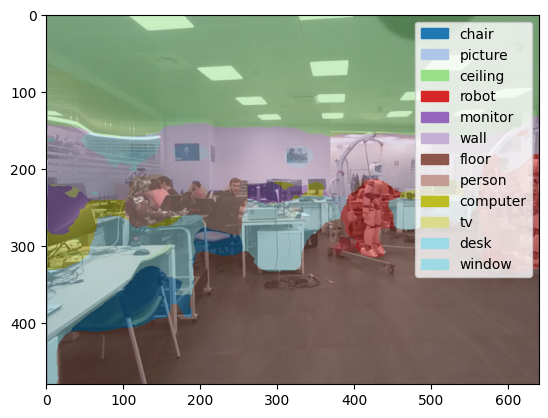

In [6]:
# visualize the output as a segmentation mask

import matplotlib.pyplot as plt
import numpy as np
import cv2

index = 0

sample = ds[index]

image = sample['image'].permute(1, 2, 0).numpy()

label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}

outputs = output_list[index]
mask = outputs[0]['sem_seg'].cpu().numpy()
mask = np.argmax(mask, axis=0)
# rearrange the mask to match the original image shape
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# iterate over the mask pixels and assign the color to the corresponding label
mask_color = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float64)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = label_index_to_color_dict[mask[i, j]]

mask_color[0][0]

detected = [labels[i] for i in np.unique(mask)]
print(detected)

plt.imshow(image)
plt.imshow(mask_color, alpha=0.5)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=label_index_to_color_dict[i], label=labels[i]) for i in np.unique(mask)])

assert image.shape[:2] == mask.shape == mask_color.shape[:2], (image.shape[:2], mask.shape, mask_color.shape[:2])

plt.show()


In [9]:
# visualize the output as a segmentation mask

import matplotlib.pyplot as plt
import numpy as np
import cv2

index = 0

sample = ds[index]

image = sample['image'].permute(1, 2, 0).numpy()

label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}

outputs = output_list[index]
mask = outputs[0]['downscaled_sem_seg'].cpu().numpy()
mask = np.argmax(mask, axis=0)
# rearrange the mask to match the original image shape
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# iterate over the mask pixels and assign the color to the corresponding label
mask_color = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float64)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = label_index_to_color_dict[mask[i, j]]

mask_color[0][0]

detected = [labels[i] for i in np.unique(mask)]
print(detected)

plt.imshow(image)
plt.imshow(mask_color, alpha=0.5)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=label_index_to_color_dict[i], label=labels[i]) for i in np.unique(mask)])

assert image.shape[:2] == mask.shape == mask_color.shape[:2], (image.shape[:2], mask.shape, mask_color.shape[:2])

plt.show()


/tmp/ipykernel_287430/2981576529.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}


IndexError: tuple index out of range